In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#loading the data set
df= pd.read_excel('/workspaces/temp/healthcare_premium_prediction/premiums.xlsx')
print(df.columns)
print(df.shape)

#--13 columns and 50k data i.e rows
df.head(5)



Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')
(50000, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [8]:
#convert the columns name in lower and replace the space with "_"
# df.columns.str.replace(" ","_")
# df.columns.str.lower()
#print(df.columns)#not assigned

df.columns =df.columns.str.replace(" ","_").str.lower()
print(df.columns)

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')


In [9]:
#check null on each columns
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

##Hanlde The NA values by droping them

In [10]:
#process the 'na'
#drop or replace 
#its too less na value in data set 12,13  so just drop
df.dropna(inplace=True)
df.isna().sum()


age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [11]:
#check is duplicate present (row)
df.duplicated().sum() #not present
#if present then handle by 
df.drop_duplicates(inplace=True)


In [12]:
#lets check the statistic of the  data set
df.describe()

#min age 18 and max 356 (outlier )
#number_of_dependants	 1.7 to 5 -3 present(error)
#income min 1 lakh and max 930 lakh (9.3 cr){may be an outlier}


,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [13]:
df[df.number_of_dependants<0].shape
#there are 72 rows with negative no of dependent
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

Handle negative number_of_dependants	 columns value by changing them to postive values

In [14]:
for idx, row in df.iterrows():
    if row['number_of_dependants'] < 0:
        df.at[idx, 'number_of_dependants'] = abs(row['number_of_dependants'])

# row from df.iterrows() is a tuple:
# It returns a tuple like (index, Series
#so idx is the index of the df and row is pd series not a df
df[df.number_of_dependants<0].shape

(0, 13)

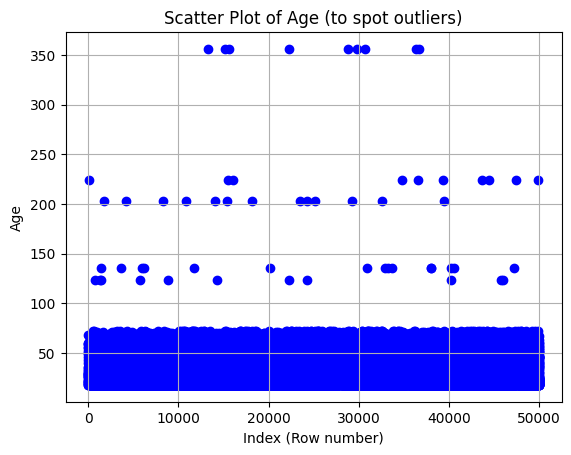

In [15]:
#detecting outlier of each columns 
import matplotlib.pyplot as plt

plt.scatter(df.index,df['age'],color='blue')
plt.title('Scatter Plot of Age (to spot outliers)')
plt.xlabel('Index (Row number)')
plt.ylabel('Age')
plt.grid(True)
plt.show()


In [16]:
#lets use 100 threshold 
#i.e age >100 will be outlier
df[df.age>100].shape
#58 rows 



(58, 13)

In [17]:
#drop the outliers of age 
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [18]:
#use iqr method to find the outlier 
# Q1 (25th percentile): 25% of the data is below this value.
# Q3 (75th percentile): 75% of the data is below this value.
# IQR: Measures the middle 50% of your data
def get_iqr_bounds(col):
    Q1 ,Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 -1.5 *IQR
    upper_bound = Q3 +1.5 * IQR
    #Any value outside this range is considered an outlier.

    return upper_bound,lower_bound



In [19]:
upper,lower = get_iqr_bounds(df1['income_lakhs'])
print(upper,lower)#its says 67 lakh is upper bound 
#but its not un-natural to have more then 67 lakh income

#lets check the  quantile 0.999 i.e income values 99 % of data below that value 
print(df1['income_lakhs'].quantile(0.999))#its says 100 lakh income value i.e 99% of the row have less than 100 lakh income
print(df1[df.income_lakhs>100].shape)#check the count of >100  lakh income rows

#only 10 rows lets drop them 
df2= df1[df1.income_lakhs < 100].copy()
print(df2.shape)
print(df2.describe())



67.0 -29.0
100.0
(10, 13)
(49808, 13)
                age  number_of_dependants  income_lakhs  annual_premium_amount
count  49808.000000          49808.000000  49808.000000           49808.000000
mean      34.399333              1.717214     22.735083           15756.332276
std       13.683206              1.492056     21.921788            8417.581174
min       18.000000              0.000000      1.000000            3501.000000
25%       22.000000              0.000000      7.000000            8602.000000
50%       31.000000              2.000000     16.000000           13919.000000
75%       45.000000              3.000000     31.000000           22263.250000
max       72.000000              5.000000     99.000000           43471.000000


/tmp/ipykernel_38023/334995210.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df1[df.income_lakhs>100].shape)#check the count of >100  lakh income rows


<Axes: xlabel='income_lakhs', ylabel='Count'>

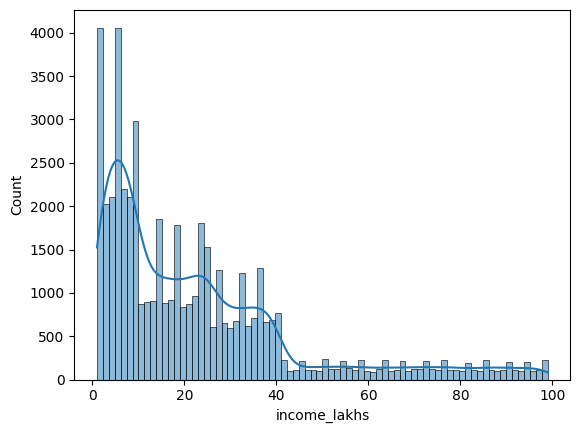

In [20]:
sns.histplot(df2['income_lakhs'],kde=True)

#majority of the people have income <40 lakh by histplot

<Axes: xlabel='age', ylabel='Count'>

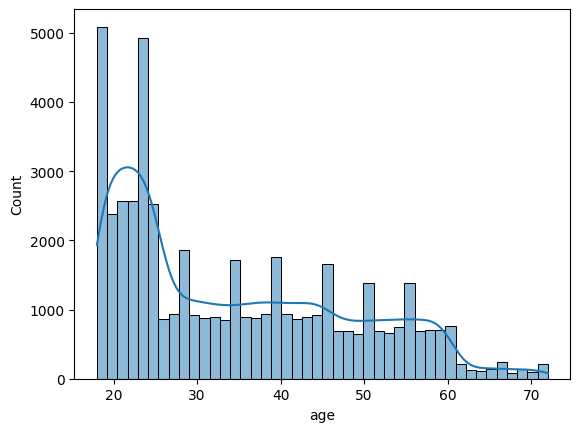

In [21]:
sns.histplot(df2['age'],kde=True)
#majority age is <60

<Axes: xlabel='number_of_dependants', ylabel='Count'>

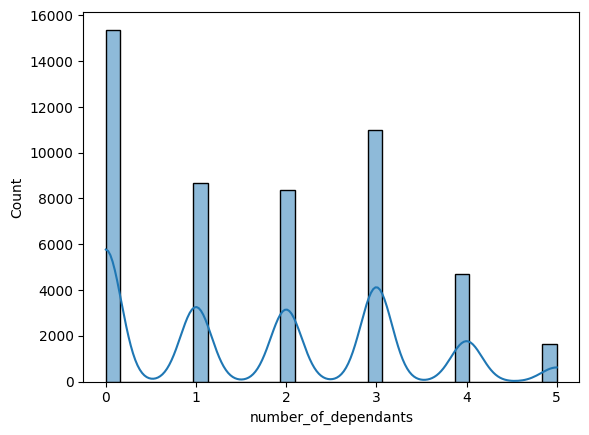

In [22]:
sns.histplot(df2['number_of_dependants'],kde=True)

<Axes: xlabel='annual_premium_amount', ylabel='Count'>

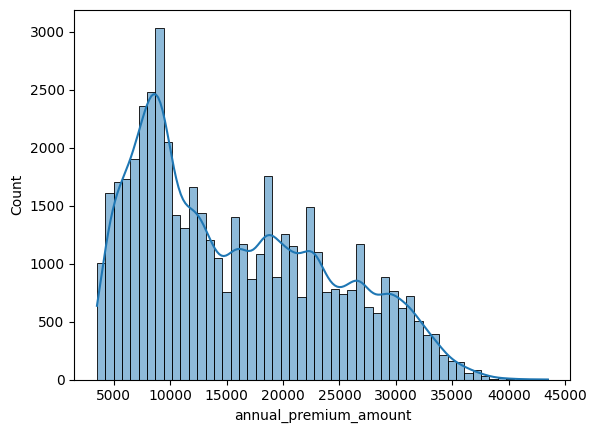

In [23]:
sns.histplot(df['annual_premium_amount'],kde=True)

<Axes: xlabel='age', ylabel='annual_premium_amount'>

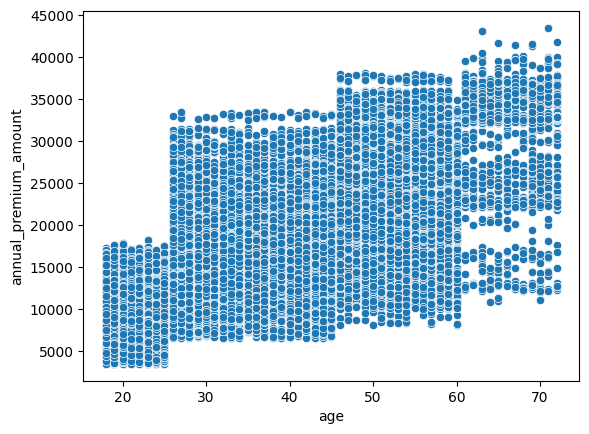

In [24]:
sns.scatterplot(df2,x='age',y='annual_premium_amount')

In [25]:
#Check the categorical columns data
#df2.columns
categorical_cols = ['gender', 'region', 'marital_status',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col,":",df2[col].unique())


#In smoking column replace 'Smoking=0' 'Does Not Smoke''No Smoking' is same have to fix this
#  

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


Fixing smoking status cols values 


In [26]:
for idx,row in df2.iterrows():
    if row['smoking_status'] == 'Smoking=0'or  row['smoking_status'] == 'Not Smoking'or row['smoking_status'] == 'Does Not Smoke':
        df2.at[idx,'smoking_status'] = 'No Smoking'
    elif row['smoking_status'] == 'No Smoking ':
        df2.at[idx,'smoking_status'] = 'No Smoking'

print(df2['smoking_status'].unique())

['No Smoking' 'Regular' 'Occasional']


In [27]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

Assigning risk scores to the'medical_history' column cause its essential to allow the regression model to compute and learn from this feature

In [28]:
medical_score_map = {
    'No Disease': 0,
    'Thyroid': 1,
    'High blood pressure': 2,
    'Diabetes': 3,
    'Heart disease': 4,
    'Diabetes & Thyroid': 4,
    'Diabetes & High blood pressure': 5,
    'High blood pressure & Heart disease': 6,
    'Diabetes & Heart disease': 7
}


In [29]:
#adding a new column 'medical_score' based on the medical history
df2['medical_score'] = 0  # Initialize with 0
for idx, row in df2.iterrows():
   if row['medical_history'] in medical_score_map:
        df2.at[idx, 'medical_score'] = medical_score_map[row['medical_history']]
   else:
        df2.at[idx, 'medical_score'] = 0

print(df2['medical_score'].unique())

#print the df2 columns
#print(df2.columns)
#print(df2.head(1))
#normalize the risk score 
min_score = df2['medical_score'].min()
max_score = df2['medical_score'].max()
df2['normalized_risk_score'] = (df2['medical_score']- min_score) / (max_score - min_score)
print(df2.columns)




[3 2 0 5 1 4 6 7]
Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'medical_score', 'normalized_risk_score'],
      dtype='object')


In [30]:
#Insurance plan is categorical column

print(df2['insurance_plan'].unique())

['Bronze' 'Silver' 'Gold']


In [31]:
#lets convert it to numerical value
df2['insurance_plan_numerical'] = 0
for idx,row in df2.iterrows():
    if row['insurance_plan'] == "Bronze":
        df2.at[idx,'insurance_plan_numerical'] = 1
    elif row['insurance_plan'] == "Silver":
        df2.at[idx,'insurance_plan_numerical'] = 2
    elif row['insurance_plan'] == "Gold":  
        df2.at[idx,'insurance_plan_numerical'] = 3
    else :
        df2.at[idx,'insurance_plan_numerical'] = 0

print(df2['insurance_plan_numerical'].unique())

[1 2 3]


In [32]:
#check the employment status
print(df2['employment_status'].unique())

['Salaried' 'Self-Employed' 'Freelancer']


In [33]:
employment_status_map = {
    'Freelancer': 1,
    'Self-Employed': 2,
    'Salaried': 3
}

df2['employment_score'] = df2['employment_status'].map(employment_status_map)
print(df2['employment_score'].unique())

[3 2 1]


['No Smoking' 'Regular' 'Occasional']


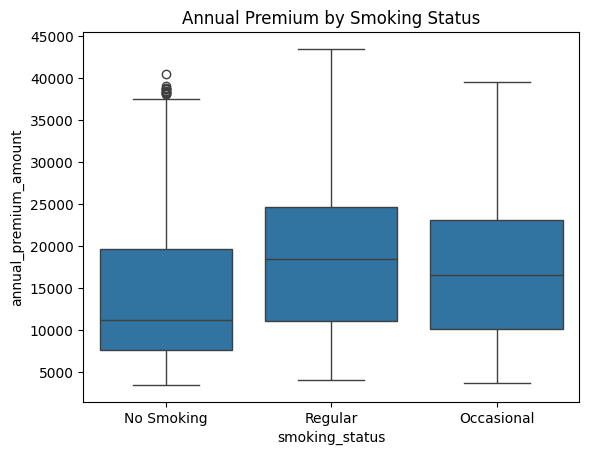

In [34]:
print(df2['smoking_status'].unique())
#if smoking status and 'annual_premium_amount' have relation or not
sns.boxplot(x='smoking_status', y='annual_premium_amount', data=df2)
plt.title('Annual Premium by Smoking Status')
plt.show()

Conclusion the No smoking people have avg insurance plan of 10k and for regular its around ~20k and occasional its around 18k
Consider this column in model decision attribute

In [35]:
# Convert the smoking_status column into numeric values 
smoking_status_map = {
    'Regular': 3,      
    'Occasional': 2,  
    'No': 1            
}

df2['smoking_score'] = 0


for idx, row in df2.iterrows():
    if row['smoking_status'] in smoking_status_map:
        df2.at[idx, 'smoking_score'] = smoking_status_map[row['smoking_status']]
    else:
        df2.at[idx, 'smoking_score'] = 1 
print(df2['smoking_score'].unique())


[1 3 2]


In [36]:
#check the correlation of the age and annual premium amount
correlation = df2[['age', 'annual_premium_amount']].corr().iloc[0, 1]
#iloc[0, 1] gives the correlation value between the two columns where 0 is the first column (age) and 1 is the second column (annual_premium_amount).
print(f"Correlation between age and annual premium amount: {correlation}")
#corelation > 0.5 means there is a strong positive correlation between age and annual premium amount



Correlation between age and annual premium amount: 0.7678007810327658


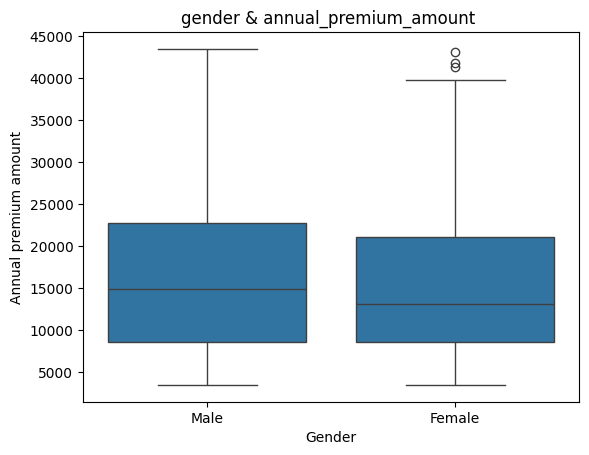

In [37]:
#now lets check do the gender have any relation with the target column
sns.boxplot(x='gender', y='annual_premium_amount', data=df2)
plt.title('gender & annual_premium_amount ')
plt.xlabel('Gender')
plt.ylabel('Annual premium amount')

plt.show()

#conclusion 
Median for Male > Female	On average, males pay slightly higher premiums than female male median amount 15k female ~13k


In [38]:
#lets use  t-test  to get an conclusion to drop or not
#If p < 0.05, the difference is statistically significant.

#If p >= 0.05, then gender likely does not matter  drop it.
from scipy.stats import ttest_ind

male = df2[df2['gender'] == 'Male']['annual_premium_amount']
female = df2[df2['gender'] == 'Female']['annual_premium_amount']

stat, p = ttest_ind(male, female)

print(f"P-value: {p}")


P-value: 8.845846367057283e-47


The value of test is almost ~0 so have its means gender have significant affect on premium_amount ,So not going to drop

In [39]:
#save the data frame to excel file
df2.to_excel('processed_premiums.xlsx', index=False)